In [1]:
import os
import numpy as np
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.preprocessing import image
from PIL import Image, ImageOps
import cv2
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, ELU, Dropout, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate


In [2]:

# Image resizing parameters
img_rows, img_cols = 64, 64
isolated_train_path = 'D:/CXR8/ChestX-ray'
isolated_test_path = 'D:/CXR8/ChestX-ray Test'

In [3]:

# Preprocess images
for root, dirnames, filenames in os.walk(isolated_train_path):
    for filename in filenames:
        file_path = os.path.join(root, filename)
        img = Image.open(file_path)
        Grey = img.resize((img_rows, img_cols))
        Grey = Grey.convert('RGB')
        Grey.save(file_path)

In [4]:
# Paths for training and validation data
train_data_dir = isolated_train_path 
validation_data_dir = isolated_test_path

In [5]:
# Image data parameters
img_width, img_height, channel = img_rows, img_cols, 3
batch_size = 64

In [6]:
# Data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [7]:
# Training and validation data generators
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical'
)


Found 10500 images belonging to 15 classes.


In [8]:
validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)

Found 2100 images belonging to 15 classes.


In [9]:
# Model parameters
IMG_SHAPE = img_cols, img_rows, 3
classes = 15
num_epoch = 30
num_train_samples = train_generator.samples
###################################################num_train_samples =  train_data_dir
num_validation_samples = validation_generator.samples

################################################### num_validation_samples = validation_data_dir

In [10]:
print('num_train_samples: ' + str(num_train_samples))
print('num_validation_samples: ' + str(num_validation_samples))

num_train_samples: 10500
num_validation_samples: 2100


In [11]:

# Model building functions
def batch_normalization_relu_conv(x, filters, kernel_size):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

In [12]:
def dense_block(tensor, k, reps):
    for _ in range(reps):
        x = batch_normalization_relu_conv(tensor, filters=4*k, kernel_size=1)
        x = batch_normalization_relu_conv(x, filters=k, kernel_size=3)
        tensor = Concatenate()([tensor, x])
    return tensor

In [13]:
def transition_layer(x, theta):
    f = int(tensorflow.keras.backend.int_shape(x)[-1] * theta)
    x = batch_normalization_relu_conv(x, filters=f, kernel_size=1)
    x = AvgPool2D(pool_size=2, strides=2, padding='same')(x)
    return x

In [72]:
# Model architecture
k = 8 # 12 actual .. then 
theta = 0.5
repetitions = 10, 14, 16
input_layer = Input(IMG_SHAPE)
x = Conv2D(2*k, 7, strides=2, padding='same')(input_layer)
x = Dropout(0.1)(x) #  actual 0.2
x = MaxPool2D(3, strides=2, padding='same')(x) # 3 actual 

In [73]:
for reps in repetitions:
    x = dense_block(x, k, reps)
    x = transition_layer(x, theta)

In [74]:
x = GlobalAvgPool2D()(x)
output_layer = Dense(classes, activation='softmax')(x)

In [75]:
model = Model(input_layer, output_layer)
model.summary()


Model: "model_12"
__________________________________________________________________________________________________


 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_679 (Conv2D)            (None, 16, 16, 16)   2368        ['input_15[0][0]']               
                                                                                                  
 dropout_14 (Dropout)           (None, 16, 16, 16)   0           ['conv2d_679[0][0]']             
                                                                                                  
 max_pooling2d_14 (MaxPooling2D  (None, 8, 8, 16)    0           ['dropout_14[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_68

In [76]:
# Model compilation
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001) # 0.001 actual
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [70]:
# Model training
history_1 = model.fit(
    train_generator,
    steps_per_epoch=num_train_samples // batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=num_validation_samples // batch_size
)

Epoch 1/30
82/82 [==============================] - 32s 387ms/step - loss: 2.5790 - accuracy: 0.1370 - val_loss: 2.7515 - val_accuracy: 0.0786
Epoch 2/30
82/82 [==============================] - 30s 368ms/step - loss: 2.5753 - accuracy: 0.1443 - val_loss: 2.5963 - val_accuracy: 0.1431
Epoch 3/30
82/82 [==============================] - 30s 371ms/step - loss: 2.5750 - accuracy: 0.1348 - val_loss: 2.6277 - val_accuracy: 0.1328
Epoch 4/30
82/82 [==============================] - 30s 370ms/step - loss: 2.5722 - accuracy: 0.1409 - val_loss: 2.6053 - val_accuracy: 0.1348
Epoch 5/30
82/82 [==============================] - 30s 369ms/step - loss: 2.5772 - accuracy: 0.1400 - val_loss: 2.6409 - val_accuracy: 0.1309
Epoch 6/30
82/82 [==============================] - 30s 369ms/step - loss: 2.5685 - accuracy: 0.1428 - val_loss: 2.7092 - val_accuracy: 0.0840
Epoch 7/30
82/82 [==============================] - 30s 372ms/step - loss: 2.5705 - accuracy: 0.1420 - val_loss: 2.6419 - val_accuracy: 0.1118

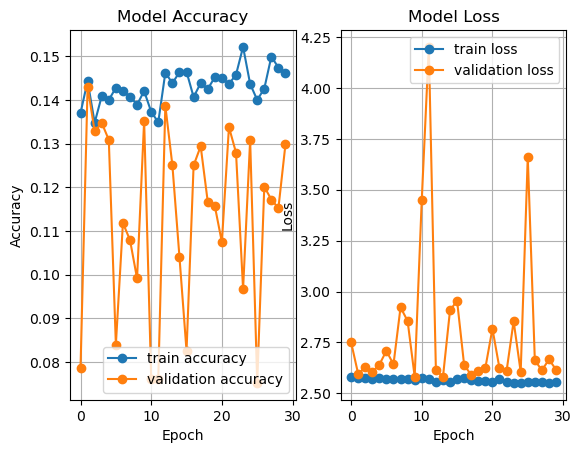

In [71]:
# Plot training & validation accuracy values
plt.subplot(1,2,1)
plt.plot(history_1.history['accuracy'], 'o-', label='train accuracy')
plt.plot(history_1.history['val_accuracy'], 'o-', label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history_1.history['loss'], 'o-', label='train loss')
plt.plot(history_1.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [44]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [47]:
Y_pred = model.predict(validation_generator, num_validation_samples// batch_size)
print(Y_pred.shape)
y_pred = np.argmax(Y_pred, axis=1)
y_true= validation_generator.classes

target_names = ['62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76' ]
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

79/79 [==============================] - 17s 212ms/step
(1580, 15)
              precision    recall  f1-score   support

          62      0.180     0.162     0.171       111
          63      0.333     0.342     0.338       111
          64      0.255     0.108     0.152       111
          65      0.573     0.532     0.551       111
          66      0.230     0.153     0.184       111
          67      0.136     0.216     0.167       111
          68      0.027     0.259     0.049        27
          69      0.807     0.645     0.717       110
          70      0.091     0.027     0.042       111
          71      0.141     0.126     0.133       111
          72      0.183     0.117     0.143       111
          73      0.206     0.261     0.230       111
          74      0.095     0.036     0.052       111
          75      0.483     0.631     0.547       111
          76      0.149     0.117     0.131       111

    accuracy                          0.248      1580
   macro avg 